In [7]:
# !pip install textblob
# !pip uninstall typing -y
# !pip install flair
# !pip install googletrans

In [8]:
from textblob import TextBlob
import pandas as pd
from tqdm.notebook import tqdm
import re
import numpy as np
import warnings
from googletrans import Translator
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
ad_data = pd.read_csv('../libs/facebook_ad_Senate_v2.csv', low_memory=False)
print("Ads data shape : ", end = " ") ; print(ad_data.shape)
ad_data.dropna(subset=['candidate'], inplace=True)
print("\n%s rows remaning after dropping 'nan' candidates"%(ad_data.shape[0]))
ad_data.head()

Ads data shape :  (1002439, 30)

48087 rows remaning after dropping 'nan' candidates


id          state         candidate       party  \
0  1.008560e+14        Montana        Jon Tester  Democratic   
1  1.019970e+14  Massachusetts  Elizabeth Warren  Democratic   
2  1.026676e+14        Arizona    Kyrsten Sinema  Democratic   
3  1.031106e+14          Texas     Beto O'Rourke  Democratic   
4  1.035633e+14  Massachusetts  Elizabeth Warren  Democratic   

    competitiveness      status vote_results  vote_pct ad_start_time  \
0            Tossup   Incumbent          Won      0.50     5/15/2018   
1  Solid Democratic   Incumbent          Won      0.60     5/20/2018   
2            Tossup        Open          Won      0.50     5/22/2018   
3            Tossup  Challenger         Lost      0.48     9/27/2018   
4  Solid Democratic   Incumbent          Won      0.60     9/28/2018   

  ad_stop_time  ...  impressions_upper  male female age18_24 age25_34  \
0    5/17/2018  ...            14999.0  0.40   0.60     0.06     0.16   
1    5/21/2018  ...             1999.0  1.00   0.00     0.00     0.00   
2    5/31/2018  ...              999.0  0.35   0.64     0.07     0.10   
3    9/27/2018  ...             1999.0  0.39   0.61     0.74     0.25   
4    9/30/2018  ...             5999.0  0.24   0.75     0.00     0.00   

  age35_44 age45_54  age55_64  age65plus  \
0     0.18     0.17      0.21       0.22   
1     0.00     0.00      1.00       0.00   
2     0.12     0.17      0.27       0.25   
3     0.00     0.00      0.00       0.00   
4     0.00     0.19      0.43       0.37   

                                     ad_snapshot_url  
0  https://www.facebook.com/ads/archive/render_ad...  
1  https://www.facebook.com/ads/archive/render_ad...  
2  https://www.facebook.com/ads/archive/render_ad...  
3  https://www.facebook.com/ads/archive/render_ad...  
4  https://www.facebook.com/ads/archive/render_ad...  

[5 rows x 30 columns]

In [11]:
issues_data = pd.read_csv("../libs/df_merged_topics.csv", low_memory=False)
print("Issue data shape : ", end = " ") ; print(issues_data.shape)

Issue data shape :  (48705, 88)


In [12]:
issues_data.head()

Unnamed: 0            id          state         candidate       party  \
0           0  1.008560e+14        Montana        Jon Tester  Democratic   
1           1  1.019970e+14  Massachusetts  Elizabeth Warren  Democratic   
2           2  1.026676e+14        Arizona    Kyrsten Sinema  Democratic   
3           3  1.031106e+14          Texas     Beto O'Rourke  Democratic   
4           4  1.035633e+14  Massachusetts  Elizabeth Warren  Democratic   

    competitiveness      status vote_results  vote_pct ad_start_time  ...  \
0            Tossup   Incumbent          Won      0.50     5/15/2018  ...   
1  Solid Democratic   Incumbent          Won      0.60     5/20/2018  ...   
2            Tossup        Open          Won      0.50     5/22/2018  ...   
3            Tossup  Challenger         Lost      0.48     9/27/2018  ...   
4  Solid Democratic   Incumbent          Won      0.60     9/28/2018  ...   

  issue_russia  issue_mexico issue_meast                           topic  \
0          0.0           0.0         0.0                         unclear   
1          0.0           0.0         0.0  Healthcare cost, law and order   
2          0.0           0.0         0.0                       Kavanaugh   
3          0.0           0.0         0.0              Meet the candidate   
4          0.0           0.0         0.0                       Kavanaugh   

  donate_issues economic_issues social_issues social_welfare_issues  \
0             0               1             0                     0   
1             0               1             0                     0   
2             0               0             0                     0   
3             0               0             0                     0   
4             0               1             0                     0   

   law_order_issues  security_and_foreign_policy_issues  
0                 0                                   0  
1                 0                                   0  
2                 0                                   0  
3                 0                                   0  
4                 0                                   1  

[5 rows x 88 columns]

In [13]:
issues_data.columns

Index(['Unnamed: 0', 'id', 'state', 'candidate', 'party', 'competitiveness',
       'status', 'vote_results', 'vote_pct', 'ad_start_time', 'ad_stop_time',
       'page_id', 'page_name', 'funding_entity', 'ad_body_text',
       'ad_link_caption', 'ad_link_description', 'ad_link_title',
       'spend_lower', 'spend_upper', 'impressions_lower', 'impressions_upper',
       'male', 'female', 'age18_24', 'age25_34', 'age35_44', 'age45_54',
       'age55_64', 'age65plus', 'ad_snapshot_url', 'issue_content',
       'issue_economy', 'issue_tax', 'issue_business', 'issue_jobs',
       'issue_income', 'issue_housing', 'issue_spending', 'issue_trade',
       'issue_infrastructure', 'issue_farming', 'issue_energy',
       'issue_drilling', 'issue_environment', 'issue_disaster', 'issue_lands',
       'issue_tourism', 'issue_abortion', 'issue_race', 'issue_gender',
       'issue_violence', 'issue_assault', 'issue_guns', 'issue_lgbt',
       'issue_healthcare', 'issue_opioid', 'issue_education', 'issu

***
# Ad runtime

In [18]:
from datetime import datetime
from datetime import date

In [19]:
def duration_calc(f_date, l_date):
    f_date = [int(x) for x in f_date.split("/")]
    l_date = [int(x) for x in l_date.split("/")]
    delta = date(l_date[2],l_date[0],l_date[1]) - date(f_date[2],f_date[0],f_date[1])
    return delta.days

In [16]:
issues_data['runtime_days'] = issues_data.apply(lambda row: duration_calc(row.ad_start_time,row.ad_stop_time)+1, axis = 1)

***
# Merging Topics/Issues

In [17]:
other_economic = ["issue_economy", "issue_business", "issue_income", 
                  "issue_housing", "issue_spending", "issue_infrastructure", 
                  "issue_energy", "issue_drilling", "issue_disaster", "issue_lands", "issue_tourism"]
other_social = ["issue_gender", "issue_violence", "issue_assault", "issue_lgbt"]
other_social_welfare = ["issue_leave", "issue_socialsecurity", "issue_welfare"]
other_law_and_order = ["issue_police", "issue_drugs", "issue_marijuana", "issue_trafficking",
                        "issue_electoral"]
other_security_and_foreign_policy = [ "issue_defense", "issue_terrorism", "issue_nuclear", 
                                     "issue_iran", "issue_china", "issue_nkorea", "issue_russia", "issue_mexico", "issue_meast"]

In [18]:
def gen_colum(df, col_list, col_name):
    new_col = np.zeros(len(df))
    for i in tqdm(range(len(new_col))):
        for col in col_list:
            try:
                if int(df[col][i]) == 1:
                    new_col[i] = 1
                    break
            except:
                continue
    df[col_name] = new_col       
    return df

In [19]:
issues_data = gen_colum(issues_data,other_economic,'other_economic')
issues_data = gen_colum(issues_data,other_social,'other_social')
issues_data = gen_colum(issues_data,other_social_welfare,'other_social_welfare')
issues_data = gen_colum(issues_data,other_law_and_order,'other_law_and_order')
issues_data = gen_colum(issues_data,other_security_and_foreign_policy,'other_security_and_foreign_policy')

In [20]:
issues_data.drop(other_economic, inplace=True ,axis=1)
issues_data.drop(other_social, inplace=True ,axis=1)
issues_data.drop(other_social_welfare, inplace=True ,axis=1)
issues_data.drop(other_law_and_order, inplace=True ,axis=1)
issues_data.drop(other_security_and_foreign_policy, inplace=True ,axis=1)
issues_data.drop(['Unnamed: 0'], inplace=True ,axis=1)

In [21]:
issues_data.columns

Index(['id', 'state', 'candidate', 'party', 'competitiveness', 'status',
       'vote_results', 'vote_pct', 'ad_start_time', 'ad_stop_time', 'page_id',
       'page_name', 'funding_entity', 'ad_body_text', 'ad_link_caption',
       'ad_link_description', 'ad_link_title', 'spend_lower', 'spend_upper',
       'impressions_lower', 'impressions_upper', 'male', 'female', 'age18_24',
       'age25_34', 'age35_44', 'age45_54', 'age55_64', 'age65plus',
       'ad_snapshot_url', 'issue_content', 'issue_tax', 'issue_jobs',
       'issue_trade', 'issue_farming', 'issue_environment', 'issue_abortion',
       'issue_race', 'issue_guns', 'issue_healthcare', 'issue_opioid',
       'issue_education', 'issue_veterans', 'issue_crime', 'issue_courts',
       'issue_corruption', 'issue_military', 'issue_immigration', 'topic',
       'donate_issues', 'economic_issues', 'social_issues',
       'social_welfare_issues', 'law_order_issues',
       'security_and_foreign_policy_issues', 'runtime_days', 'other_ec

***
# Language Detection and Translation

In [22]:
ad_text_issue = issues_data['ad_body_text'].unique()
ad_text_issue = pd.DataFrame(ad_text_issue, columns=["ad_body_text"])
print(len(ad_text_issue))
ad_text_issue.head()

7069


ad_body_text
0  I’m leading a bipartisan coalition of business...
1  The bank lobbyists have a Dodd-Frank rollback ...
2  Do you think politicians should be able to mak...
3  Come meet Congressman Beto O'Rourke at UT Arli...
4  Brett Kavanaugh has shown us that it’s more im...

In [23]:
translator = Translator()
def detect_lang(text):
    lang = translator.translate(text).src
    if lang == 'es':
        return "spanish"
    else:
        return "english"

def translate_lang(text,lang):
    if lang == "spanish":
        return translator.translate(text).text
    else:
        return text

In [ ]:
tqdm.pandas()
ad_text_issue['ad_lang'] = ad_text_issue.progress_apply(lambda row : detect_lang(str(row.ad_body_text)),axis = 1 )
ad_text_issue['en_text'] = ad_text_issue.progress_apply(lambda row : translate_lang(str(row.ad_body_text), row.ad_lang),axis = 1 )

In [ ]:
ad_text_issue.to_csv('issues_with_sentiemnt.csv', index = False)

****
# Sentiment Analysis

### Sentiment analysis using TextBlob

In [90]:
ad_text_issue['textblob_polarity'] = ad_text_issue.apply(lambda row: round(TextBlob(str(row.en_text)).sentiment[0],3), axis = 1)
ad_text_issue['textblob_objectivity'] = ad_text_issue.apply(lambda row: round(TextBlob(str(row.en_text)).sentiment[1],3), axis = 1)

In [16]:
# issues_data[['ad_body_text','textblob_polarity','textblob_objectivity']].head(20)

### Sentimment analysis using Flair

In [91]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2020-10-30 19:24:57,918 loading file /home/jovyan/.flair/models/sentiment-en-mix-distillbert_3.1.pt


In [92]:
def flair_sent(text):    
    s = flair.data.Sentence(text)
    flair_sentiment.predict(s)
    sentiment = s.labels
    sentiment_label = str(sentiment[0]).split(" ")[0]
    sentiment_val = float(str(sentiment[0]).split(" ")[1].strip("(,)"))
    if sentiment_label == "NEGATIVE":
        sentiment_val = sentiment_val*-1

    return sentiment_val

In [93]:
ad_text_issue['flair_sentiment'] = ad_text_issue.apply(lambda row: flair_sent(str(row.en_text)), axis = 1)
# issues_data.head(20)

### Sentiment analysis using Vader

In [94]:
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [95]:
def vader_sent(text):
    polarity = sid.polarity_scores(text)
    return polarity['compound']

In [96]:
ad_text_issue['vader_sentiment'] = ad_text_issue.apply(lambda row: vader_sent(str(row.en_text)), axis = 1)
ad_text_issue[['en_text','textblob_polarity','textblob_objectivity','flair_sentiment','vader_sentiment']].head(20)

en_text  textblob_polarity  \
0   I’m leading a bipartisan coalition of business...             -0.067   
1   The bank lobbyists have a Dodd-Frank rollback ...              0.095   
2   Do you think politicians should be able to mak...              0.500   
3   Come meet Congressman Beto O'Rourke at UT Arli...              0.167   
4   Brett Kavanaugh has shown us that it’s more im...              0.300   
5   BREAKING: OUR RACE MOVED FROM LEAN REPUBLICAN ...              0.000   
6   Are you 100% sure you’re ready to vote on Elec...              0.154   
7   Brett Kavanaugh’s testimony made one thing ver...             -0.023   
8   Tennesseans want their next U.S. Senator to ha...              0.117   
9   We must end Republican control of the Senate a...              0.000   
10  URGENT: We’re being outspent on the airwaves b...              0.000   
11  I don’t have a super PAC. I don’t have a billi...              0.382   
12  BREAKING news: the Cook Political Report just ...              0.207   
13  It's time for our economy to pay off for every...              0.283   
14  Beto is committed to fixing our broken immigra...             -0.400   
15  When I’m Senator, I’m going to act the same wa...              0.300   
16  At the first debate, Phil Bredesen made the ch...              0.230   
17  Thanks to people like you, we’re running a com...              0.251   
18  Tina Smith said Judge Brett Kavanaugh ‘committ...              0.183   
19  We are 23 days away from the start of GOTV -- ...             -0.033   

    textblob_objectivity  flair_sentiment  vader_sentiment  
0                  0.356          -0.9216          -0.5927  
1                  0.234          -0.9015          -0.4404  
2                  0.625          -0.9768           0.4939  
3                  0.167           0.9678           0.8802  
4                  0.531           0.7986           0.9321  
5                  0.100           0.9401           0.3802  
6                  0.431           0.8813           0.9287  
7                  0.466          -0.9980          -0.3276  
8                  0.239           0.8338           0.4404  
9                  0.360           0.9193          -0.5719  
10                 0.000           0.6482           0.7297  
11                 0.659          -0.6395           0.8977  
12                 0.616          -0.9227           0.8625  
13                 0.342          -0.8860           0.9231  
14                 0.400           0.9931          -0.7269  
15                 0.260           0.9903           0.8360  
16                 0.368           0.9526           0.6705  
17                 0.682           0.9953           0.8478  
18                 0.708          -0.9560           0.6597  
19                 0.413          -0.8830           0.6588

In [97]:
ad_text_issue.to_csv('issues_with_sentiemnt.csv', index = False)

# Merging the Unique Text to Main

In [71]:
# temp = pd.read_csv('issues_with_sentiemnt.csv')

In [72]:
# data_m = issues_data.set_index('ad_body_text').join(temp.set_index('ad_body_text'))

In [73]:
# data_m.to_csv('merged_issues_w_sentiment.csv', index=False)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [2]:
data_m = pd.read_csv('merged_issues_w_sentiment.csv')

data_m['avg_impressions'] = data_m.apply(lambda row: (row.impressions_lower+row.impressions_upper)/2, axis=1)
data_m['impressions_Male'] = data_m.apply(lambda row: row.avg_impressions*row.male, axis=1)
data_m['impressions_Female'] = data_m.apply(lambda row: row.avg_impressions*row.female, axis=1)
data_m['impressions_age18_24'] = data_m.apply(lambda row: row.avg_impressions*row.age18_24, axis=1)
data_m['impressions_age25_34'] = data_m.apply(lambda row: row.avg_impressions*row.age25_34, axis=1)
data_m['impressions_age35_44'] = data_m.apply(lambda row: row.avg_impressions*row.age35_44, axis=1)
data_m['impressions_age45_54'] = data_m.apply(lambda row: row.avg_impressions*row.age45_54, axis=1)
data_m['impressions_age55_64'] = data_m.apply(lambda row: row.avg_impressions*row.age55_64, axis=1)
data_m['impressions_age65plus'] = data_m.apply(lambda row: row.avg_impressions*row.age65plus, axis=1)
data_m.columns

Index(['id', 'state', 'candidate', 'party', 'competitiveness', 'status',
       'vote_results', 'vote_pct', 'ad_start_time', 'ad_stop_time', 'page_id',
       'page_name', 'funding_entity', 'ad_link_caption', 'ad_link_description',
       'ad_link_title', 'spend_lower', 'spend_upper', 'impressions_lower',
       'impressions_upper', 'male', 'female', 'age18_24', 'age25_34',
       'age35_44', 'age45_54', 'age55_64', 'age65plus', 'ad_snapshot_url',
       'issue_content', 'issue_tax', 'issue_jobs', 'issue_trade',
       'issue_farming', 'issue_environment', 'issue_abortion', 'issue_race',
       'issue_guns', 'issue_healthcare', 'issue_opioid', 'issue_education',
       'issue_veterans', 'issue_crime', 'issue_courts', 'issue_corruption',
       'issue_military', 'issue_immigration', 'topic', 'donate_issues',
       'economic_issues', 'social_issues', 'social_welfare_issues',
       'law_order_issues', 'security_and_foreign_policy_issues',
       'runtime_days', 'other_economic', 'other_

In [3]:
issues_retain = ["issue_tax","issue_jobs","issue_trade","issue_farming","issue_environment",
                "issue_abortion","issue_race","issue_guns","issue_healthcare","issue_opioid",
                "issue_education","issue_veterans","issue_crime","issue_courts","issue_corruption",
                "issue_immigration","issue_military","topic","donate_issues","economic_issues",
                "social_issues","social_welfare_issues","law_order_issues","security_and_foreign_policy_issues"]

In [4]:
for topic in issues_retain:
    if topic != "topic":
        data_m[topic] = data_m[topic]*data_m['avg_impressions']

In [9]:
focus_topics = ["issue_tax","issue_environment","issue_abortion","issue_guns","issue_healthcare",
               "issue_veterans","issue_courts","issue_immigration"]
prim_topics = ["economic_issues","social_issues","social_welfare_issues","law_order_issues","security_and_foreign_policy_issues"]

In [10]:
top12states = list((data_m.groupby(['state'])['id'].count().sort_values(ascending=False).head(12)).index)

## Consolidated Sentiment and Objectivity

In [11]:
# data_m[data_m["state"].isin(top12states)]

In [13]:
data_m.groupby(['party'])['en_text'].count()

party
Democratic     40421
Independent     1282
Libertarian        5
Republican      6070
Name: en_text, dtype: int64

In [7]:
data_m['competitiveness'].unique

<bound method Series.unique of 0                   Tossup
1                   Tossup
2                   Tossup
3          Lean Democratic
4         Solid Democratic
               ...        
48700    Likely Democratic
48701    Likely Democratic
48702               Tossup
48703               Tossup
48704               Tossup
Name: competitiveness, Length: 48705, dtype: object>

In [ ]:
data_m.groupby(['party'])['en_text'].sum()

In [9]:
data_m['avg_spend'] = data_m.apply(lambda row: (row.spend_lower+row.spend_upper)/2, axis=1)

In [10]:
data_m.groupby(['state'])['avg_spend'].sum().sort_values()

state
Hawaii                     33456.0
Maryland                   50870.0
California                 59918.5
Nebraska                   60164.0
Utah                       64980.0
Minnesota                  65467.0
Delaware                   68537.5
Rhode Island               69517.5
Mississippi (Special)      76988.5
Wyoming                    86462.0
Mississippi               102546.5
Maine                     122365.5
West Virginia             123404.0
Vermont                   142395.0
New Mexico                203187.0
Minnesota (Special)       233472.0
Connecticut               249954.0
Michigan                  460575.5
Ohio                      492303.0
Virginia                  507980.0
Washington                559421.5
Montana                   593893.0
Indiana                   646151.0
Pennsylvania              689938.0
Nevada                    736700.5
New Jersey                786168.5
Massachusetts             797891.0
New York                  922864.0
Arizona       

In [11]:
data_m[['male','female']].mean()

male      0.415673
female    0.574381
dtype: float64

In [24]:
data_m[['impressions_Male','impressions_Female']].sum()/sum(data_m[['impressions_Male','impressions_Female']].sum())

impressions_Male      0.418239
impressions_Female    0.581761
dtype: float64

In [13]:
data_m[['impressions_age18_24', 'impressions_age25_34',
       'impressions_age35_44', 'impressions_age45_54', 'impressions_age55_64',
       'impressions_age65plus']].sum()/sum(data_m[['impressions_age18_24', 'impressions_age25_34',
       'impressions_age35_44', 'impressions_age45_54', 'impressions_age55_64',
       'impressions_age65plus']].sum())

impressions_age18_24     0.121226
impressions_age25_34     0.224781
impressions_age35_44     0.194002
impressions_age45_54     0.170144
impressions_age55_64     0.152924
impressions_age65plus    0.136924
dtype: float64

In [14]:
sent_col = ['textblob_polarity','textblob_objectivity','vader_sentiment','flair_sentiment']
idx_col = ['candidate','party','vote_results','state']
sent_subset = data_m[data_m["state"].isin(top12states)].groupby(idx_col)[sent_col].mean().sort_values(by=["state"])

In [15]:
sent_subset['textblob_polarity'] = round((sent_subset['textblob_polarity']+1)*100/(2),2)
sent_subset['textblob_objectivity'] = round((sent_subset['textblob_objectivity']+1)*100/(2),2)
sent_subset['vader_sentiment'] = round((sent_subset['vader_sentiment']+1)*100/(2),2)
sent_subset['flair_sentiment'] = round((sent_subset['flair_sentiment']+1)*100/(2),2)

In [42]:
idx_col = ['state','competitiveness']
data_m.groupby(idx_col)[stats_col].mean().sort_values(by=["state"])

runtime_days      male    female
state                 competitiveness                                    
Arizona               Tossup                 5.692161  0.380099  0.609015
California            Solid Democratic       5.030303  0.485096  0.496419
Connecticut           Solid Democratic       5.872984  0.344869  0.641946
Delaware              Solid Democratic       6.382222  0.539422  0.450844
Florida               Tossup                 8.525335  0.417414  0.569866
Hawaii                Solid Democratic       5.943182  0.382159  0.600455
Indiana               Tossup                 7.144605  0.494967  0.496346
Maine                 Solid Democratic      14.757482  0.455439  0.532993
Maryland              Solid Democratic       7.883333  0.574000  0.420167
Massachusetts         Solid Democratic       4.772021  0.337094  0.651289
Michigan              Likely Democratic      9.816362  0.471070  0.520983
Minnesota             Solid Democratic      11.458647  0.428872  0.560752
Minnesota (Special)   Lean Democratic        6.165459  0.440006  0.547663
Mississippi           Solid Republican      11.219405  0.453484  0.532514
Mississippi (Special) Lean Republican       12.133127  0.479288  0.515108
Missouri              Tossup                 8.984229  0.363771  0.627097
Montana               Tossup                 4.227642  0.457322  0.531509
Nebraska              Solid Republican       9.849265  0.383419  0.607831
Nevada                Tossup                10.362651  0.442434  0.550567
New Jersey            Tossup                 9.911846  0.451570  0.540771
New Mexico            Solid Democratic      18.107029  0.435958  0.555639
New York              Solid Democratic      44.345183  0.380321  0.606170
North Dakota          Lean Republican       10.500000  0.583864  0.408939
                      Tossup                12.191076  0.376184  0.611680
Ohio                  Likely Democratic      8.597938  0.445670  0.546856
Pennsylvania          Likely Democratic      8.376603  0.398670  0.593365
Rhode Island          Solid Democratic       4.661654  0.505218  0.487278
Tennessee             Tossup                 4.564045  0.442335  0.554574
Texas                 Tossup                 5.679823  0.414677  0.575602
Utah                  Solid Republican       6.625000  0.430500  0.564000
Vermont               Solid Democratic       3.552459  0.408934  0.574738
Virginia              Solid Democratic       6.868182  0.471614  0.522500
Washington            Solid Democratic       5.802548  0.459745  0.534459
West Virginia         Lean Democratic        5.958333  0.473021  0.520937
Wisconsin             Likely Democratic      2.314357  0.386069  0.598217
Wyoming               Solid Republican      12.096591  0.466591  0.527557

In [12]:
# sent_subset

In [20]:
data_m['runtime_days'] = data_m.apply(lambda row: duration_calc(row.ad_start_time,row.ad_stop_time)+1, axis = 1)

In [37]:
stats_col = ['runtime_days','male','female']
idx_col = ['candidate','party','vote_results','state','competitiveness']
stats_subset = data_m[data_m["state"].isin(top12states)].\
                groupby(idx_col)[stats_col].mean().sort_values(by=["state"])
stats_subset

runtime_days  \
candidate        party      vote_results state               competitiveness                   
Martha McSally   Republican Lost         Arizona             Tossup                 7.880102   
Kyrsten Sinema   Democratic Won          Arizona             Tossup                 5.379825   
Bill Nelson      Democratic Lost         Florida             Tossup                 8.876569   
Rick Scott       Republican Won          Florida             Tossup                 6.745583   
Mike Braun       Republican Won          Indiana             Tossup                 7.180617   
Joe Donnelly     Democratic Lost         Indiana             Tossup                 7.132440   
Elizabeth Warren Democratic Won          Massachusetts       Solid Democratic       4.507877   
Geoff Diehl      Republican Lost         Massachusetts       Solid Democratic      11.340206   
Karin Housley    Republican Lost         Minnesota (Special) Lean Democratic        7.074830   
Tina Smith       Democratic Won          Minnesota (Special) Lean Democratic        5.969163   
Josh Hawley      Republican Won          Missouri            Tossup                13.985714   
Claire McCaskill Democratic Lost         Missouri            Tossup                 8.720000   
Matt Rosendale   Republican Lost         Montana             Tossup                 5.573333   
Jon Tester       Democratic Won          Montana             Tossup                 4.075415   
Jacky Rosen      Democratic Won          Nevada              Tossup                10.738234   
Dean Heller      Republican Lost         Nevada              Tossup                 8.964567   
Kevin Cramer     Republican Won          North Dakota        Lean Republican       10.500000   
Heidi Heitkamp   Democratic Lost         North Dakota        Tossup                12.191076   
Marsha Blackburn Republican Won          Tennessee           Tossup                 5.414216   
Phil Bredesen    Democratic Lost         Tennessee           Tossup                 4.486739   
Ted Cruz         Republican Won          Texas               Tossup                 5.910412   
Beto O'Rourke    Democratic Lost         Texas               Tossup                 5.669315   
Leah Vukmir      Republican Lost         Wisconsin           Likely Democratic      7.926230   
Tammy Baldwin    Democratic Won          Wisconsin           Likely Democratic      2.012351   

                                                                                    male  \
candidate        party      vote_results state               competitiveness               
Martha McSally   Republican Lost         Arizona             Tossup             0.513291   
Kyrsten Sinema   Democratic Won          Arizona             Tossup             0.361085   
Bill Nelson      Democratic Lost         Florida             Tossup             0.410941   
Rick Scott       Republican Won          Florida             Tossup             0.450212   
Mike Braun       Republican Won          Indiana             Tossup             0.501784   
Joe Donnelly     Democratic Lost         Indiana             Tossup             0.492664   
Elizabeth Warren Democratic Won          Massachusetts       Solid Democratic   0.328282   
Geoff Diehl      Republican Lost         Massachusetts       Solid Democratic   0.556237   
Karin Housley    Republican Lost         Minnesota (Special) Lean Democratic    0.545680   
Tina Smith       Democratic Won          Minnesota (Special) Lean Democratic    0.417195   
Josh Hawley      Republican Won          Missouri            Tossup             0.536000   
Claire McCaskill Democratic Lost         Missouri            Tossup             0.354672   
Matt Rosendale   Republican Lost         Montana             Tossup             0.522889   
Jon Tester       Democratic Won          Montana             Tossup             0.449904   
Jacky Rosen      Democratic Won          Nevada              Tossup             0.416912   
Dean Heller      Re

In [42]:
stats_col = ['en_text']
idx_col = ['candidate','party','vote_results','state']
stats_subset = data_m[data_m["state"].isin(top12states)].\
                groupby(idx_col)[stats_col].count().sort_values(by=["state"])
stats_subset

en_text
candidate        party      vote_results state                       
Martha McSally   Republican Lost         Arizona                  392
Kyrsten Sinema   Democratic Won          Arizona                 2737
Bill Nelson      Democratic Lost         Florida                 1374
Rick Scott       Republican Won          Florida                  199
Mike Braun       Republican Won          Indiana                  454
Joe Donnelly     Democratic Lost         Indiana                 1344
Elizabeth Warren Democratic Won          Massachusetts           4824
Geoff Diehl      Republican Lost         Massachusetts            194
Karin Housley    Republican Lost         Minnesota (Special)      294
Tina Smith       Democratic Won          Minnesota (Special)     1362
Josh Hawley      Republican Won          Missouri                  67
Claire McCaskill Democratic Lost         Missouri                1319
Matt Rosendale   Republican Lost         Montana                  156
Jon Tester       Democratic Won          Montana                 1971
Jacky Rosen      Democratic Won          Nevada                  1891
Dean Heller      Republican Lost         Nevada                   508
Kevin Cramer     Republican Won          North Dakota             129
Heidi Heitkamp   Democratic Lost         North Dakota            1902
Marsha Blackburn Republican Won          Tennessee                408
Phil Bredesen    Democratic Lost         Tennessee               4487
Ted Cruz         Republican Won          Texas                    413
Beto O'Rourke    Democratic Lost         Texas                   9054
Leah Vukmir      Republican Lost         Wisconsin                113
Tammy Baldwin    Democratic Won          Wisconsin               2174

In [44]:
stats_col = ['en_text']
idx_col = ['candidate','party','vote_results','state']
stats_subset = data_m[data_m["state"].isin(top12states)].\
                groupby(idx_col)[stats_col].nunique().sort_values(by=["state"])
stats_subset

en_text
candidate        party      vote_results state                       
Martha McSally   Republican Lost         Arizona                  104
Kyrsten Sinema   Democratic Won          Arizona                  150
Bill Nelson      Democratic Lost         Florida                  121
Rick Scott       Republican Won          Florida                   39
Mike Braun       Republican Won          Indiana                  152
Joe Donnelly     Democratic Lost         Indiana                   82
Elizabeth Warren Democratic Won          Massachusetts            142
Geoff Diehl      Republican Lost         Massachusetts            119
Karin Housley    Republican Lost         Minnesota (Special)       75
Tina Smith       Democratic Won          Minnesota (Special)      230
Josh Hawley      Republican Won          Missouri                  35
Claire McCaskill Democratic Lost         Missouri                 253
Matt Rosendale   Republican Lost         Montana                  108
Jon Tester       Democratic Won          Montana                  278
Jacky Rosen      Democratic Won          Nevada                   106
Dean Heller      Republican Lost         Nevada                   119
Kevin Cramer     Republican Won          North Dakota             107
Heidi Heitkamp   Democratic Lost         North Dakota             125
Marsha Blackburn Republican Won          Tennessee                142
Phil Bredesen    Democratic Lost         Tennessee                234
Ted Cruz         Republican Won          Texas                    186
Beto O'Rourke    Democratic Lost         Texas                   1111
Leah Vukmir      Republican Lost         Wisconsin                 51
Tammy Baldwin    Democratic Won          Wisconsin                127

In [23]:
stats_col = ['avg_impressions','avg_spend']
idx_col = ['candidate','party','vote_results','state']
stats_subset = data_m[data_m["state"].isin(top12states)].\
                groupby(idx_col)[stats_col].sum().sort_values(by=["state"])
stats_subset

avg_impressions  \
candidate        party      vote_results state                                  
Martha McSally   Republican Lost         Arizona                   23571305.0   
Kyrsten Sinema   Democratic Won          Arizona                   17743627.0   
Bill Nelson      Democratic Lost         Florida                   53755785.5   
Rick Scott       Republican Won          Florida                   15682858.5   
Mike Braun       Republican Won          Indiana                   15441773.5   
Joe Donnelly     Democratic Lost         Indiana                   16608828.0   
Elizabeth Warren Democratic Won          Massachusetts             46430088.0   
Geoff Diehl      Republican Lost         Massachusetts              4778903.0   
Karin Housley    Republican Lost         Minnesota (Special)        4197353.0   
Tina Smith       Democratic Won          Minnesota (Special)       11760819.0   
Josh Hawley      Republican Won          Missouri                   2628465.0   
Claire McCaskill Democratic Lost         Missouri                  50962342.0   
Matt Rosendale   Republican Lost         Montana                    5516387.5   
Jon Tester       Democratic Won          Montana                   20257505.5   
Jacky Rosen      Democratic Won          Nevada                    18320054.5   
Dean Heller      Republican Lost         Nevada                     9835746.0   
Kevin Cramer     Republican Won          North Dakota               7050434.0   
Heidi Heitkamp   Democratic Lost         North Dakota              39521547.5   
Marsha Blackburn Republican Won          Tennessee                 21256796.0   
Phil Bredesen    Democratic Lost         Tennessee                 26952256.5   
Ted Cruz         Republican Won          Texas                     42951301.5   
Beto O'Rourke    Democratic Lost         Texas                    386429490.5   
Leah Vukmir      Republican Lost         Wisconsin                  1376939.0   
Tammy Baldwin    Democratic Won          Wisconsin                 28425880.5   

                                                              avg_spend  
candidate        party      vote_results state                           
Martha McSally   Republican Lost         Arizona               348754.0  
Kyrsten Sinema   Democratic Won          Arizona               605277.0  
Bill Nelson      Democratic Lost         Florida               994383.0  
Rick Scott       Republican Won          Florida               226158.5  
Mike Braun       Republican Won          Indiana               276373.0  
Joe Donnelly     Democratic Lost         Indiana               369778.0  
Elizabeth Warren Democratic Won          Massachusetts         742188.0  
Geoff Diehl      Republican Lost         Massachusetts          55703.0  
Karin Housley    Republican Lost         Minnesota (Special)    52203.0  
Tina Smith       Democratic Won          Minnesota (Special)   181269.0  
Josh Hawley      Republican Won          Missouri               27265.0  
Claire McCaskill Democratic Lost         Missouri             1475437.5  
Matt Rosendale   Republican Lost         Montana                79687.5  
Jon Tester       Democratic Won          Montana               514205.5  
Jacky Rosen      Democratic Won          Nevada                491804.5  
Dean Heller      Republican Lost         Nevada                244896.0  
Kevin Cramer     Republican Won          North Dakota           75084.0  
Heidi Heitkamp   Democratic Lost         North Dakota         1111397.5  
Marsha Blackburn Republican Won          Tennessee             381446.0  
Phil Bredesen    Democratic Lost         Tennessee             575956.5  
Ted Cruz         Republican Won          Texas                 751543.5  
Beto O'Rourke    Democratic Lost         Texas                8271168.5  
Leah Vukmir      Republican Lost         Wisconsin              64439.0  
Tammy Baldwin    Democratic Won          Wisconsin             971766.5

# Analyzing Impressions

## Male vs Female

In [41]:
def analyze_impression(data_f, state=None, candidate=None, save=True, by_gender=True, by_age=False, threshold=0.9):
    if state == None and candidate == None:
        raise ValueError("Provide a state or a candidate value is required")
    if candidate != None:
        df = data_f[data_f["candidate"]== candidate]
    else:
        df = data_f[data_f["state"]== state]
    
    df[focus_topics].sum().plot(kind='barh', figsize=(10,5))
    plt.tight_layout()
    plt.xlabel("Number of Ads",fontsize=12)
    if candidate != None :
        plt.title(f"Candidate Topic-Wise Ads for {candidate}", fontsize=15)
    else:
        plt.title(f"Primary Topic-Wise Ads for {state}", fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=12)
    if save:
        f_name = f"topic_wise_{state}.jpg"
        plt.savefig(f"./plots/{f_name}")
    plt.show()

In [60]:
# data_m[data_m["state"].isin(["Texas","Arizona"])][data_m['male']>0.8].groupby(['state'])[focus_topics].sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


issue_tax  issue_environment  issue_abortion  issue_guns  \
state                                                               
Arizona    71975.0                0.0             0.0         0.0   
Texas          0.0                0.0             0.0         0.0   

         issue_healthcare  issue_veterans  issue_courts  issue_immigration  
state                                                                       
Arizona           96965.0         47497.5           0.0             3996.0  
Texas             12997.0             0.0           0.0             2998.0

In [69]:
# plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-dark')
# plt.style.use('tableau-colorblind10')

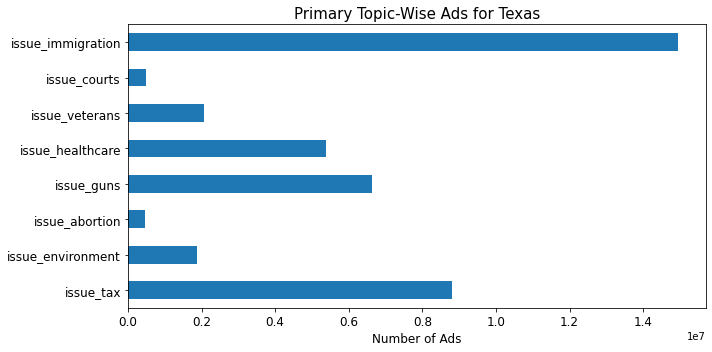

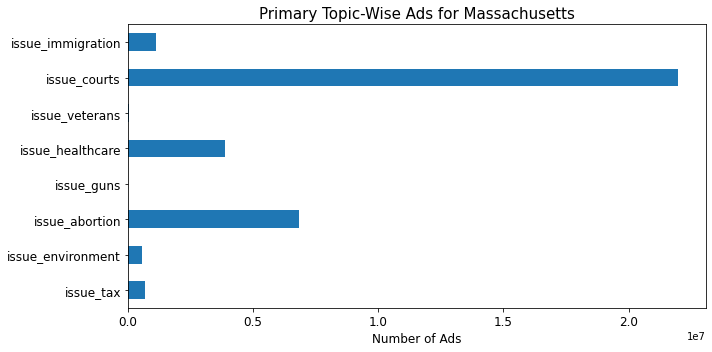

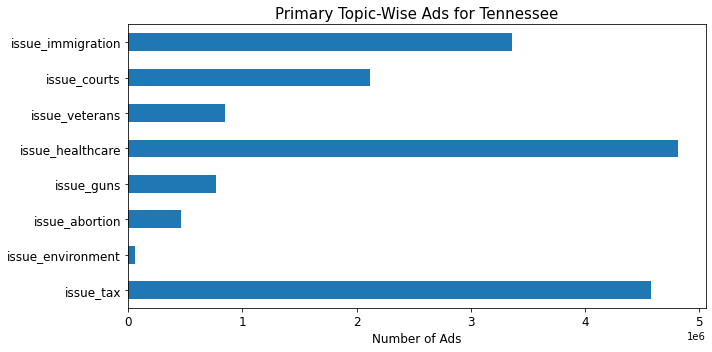

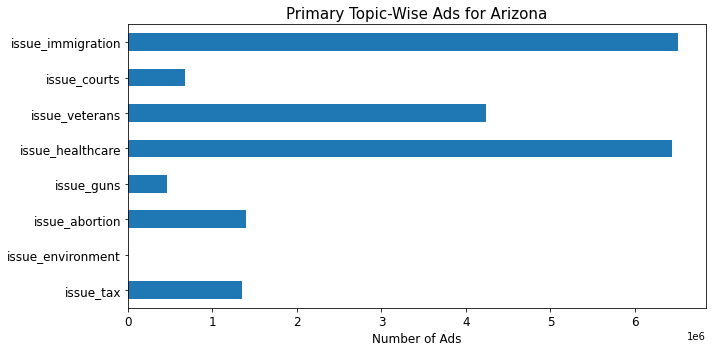

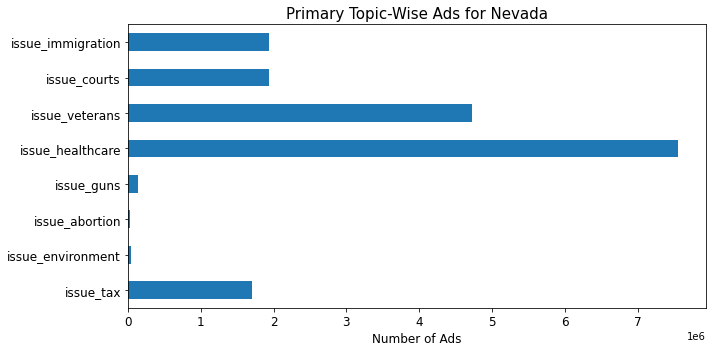

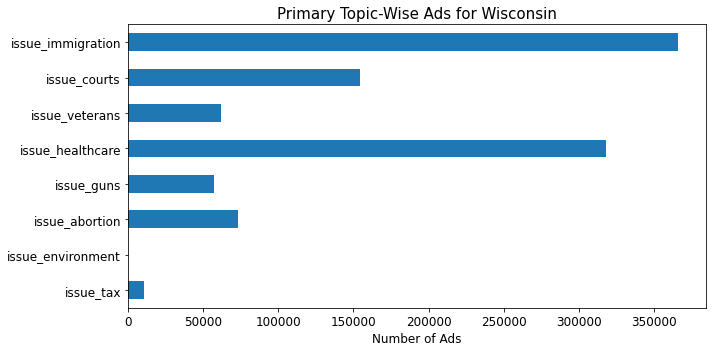

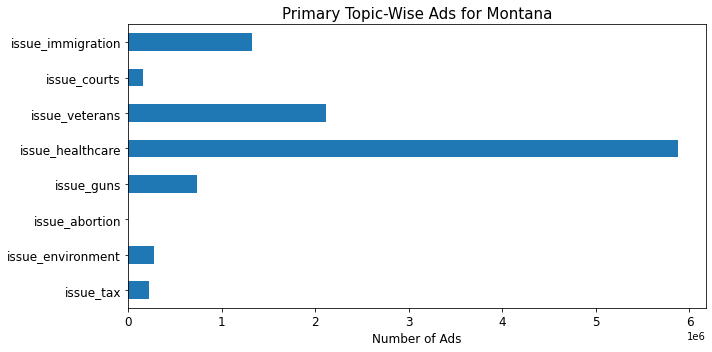

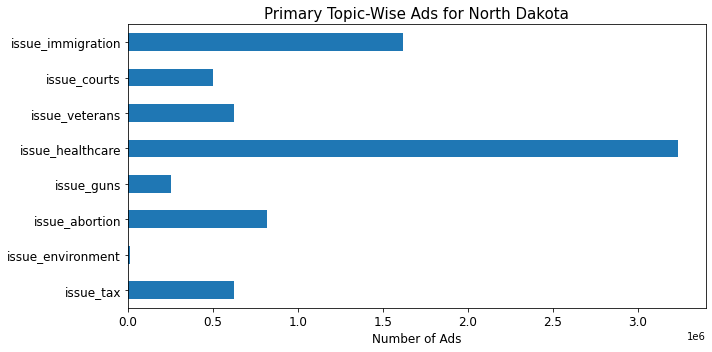

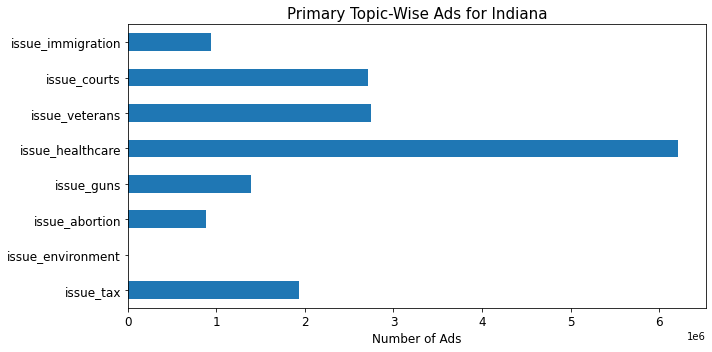

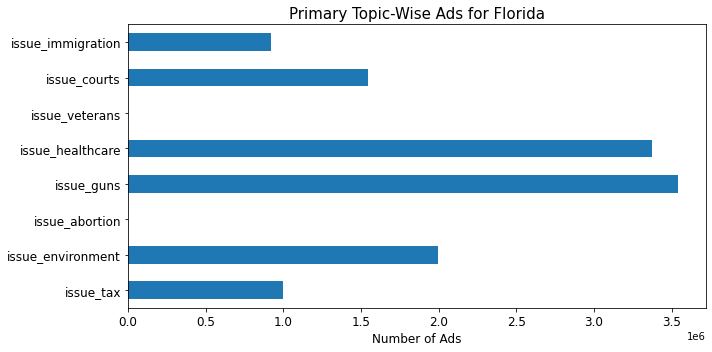

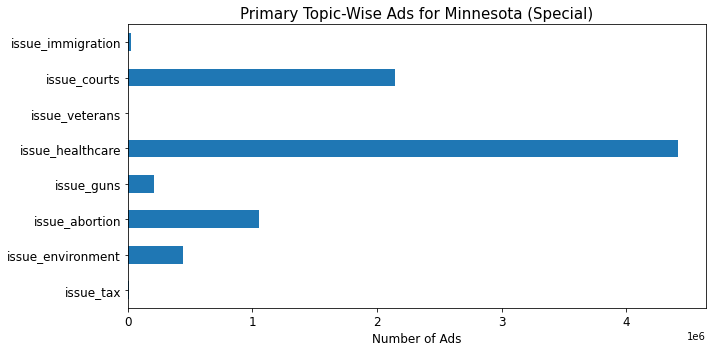

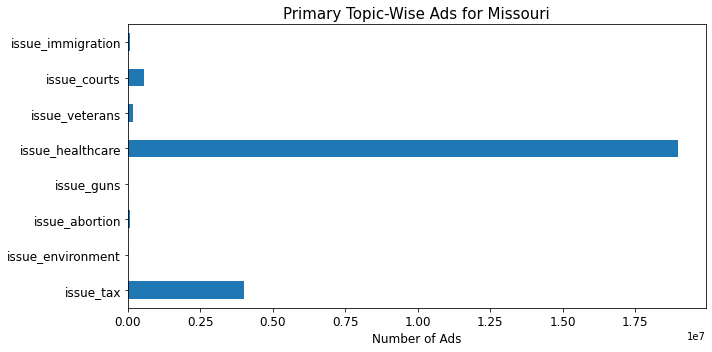

In [42]:
for state in top12states:
    analyze_impression(data_m,state,save=False)

In [49]:
candidate_top12 = data_m[data_m["state"].isin(top12states)]['candidate'].unique()

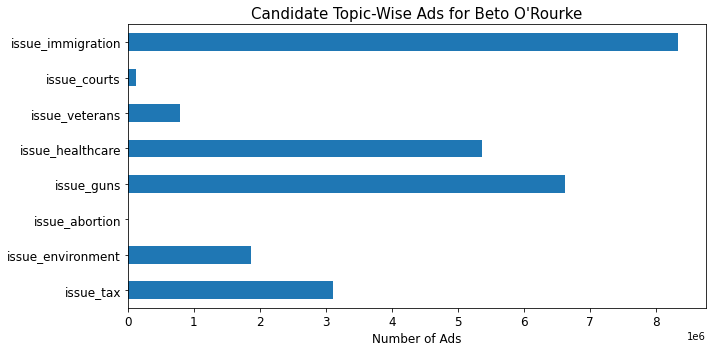

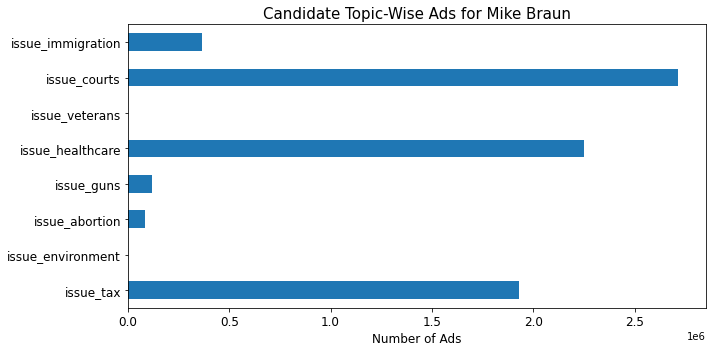

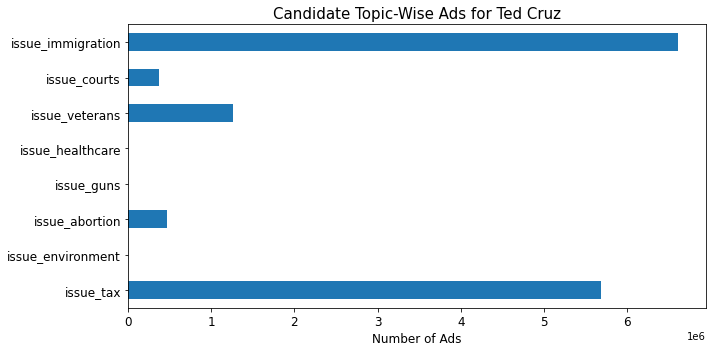

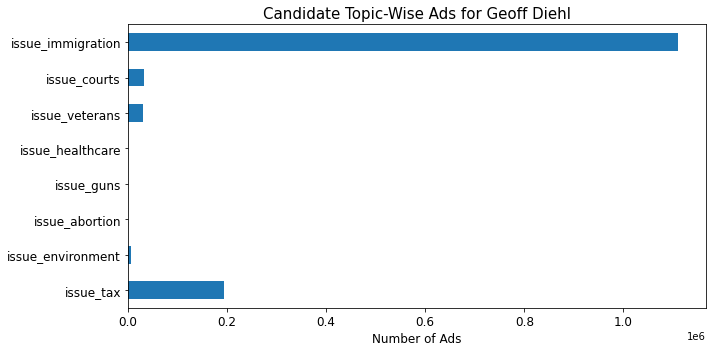

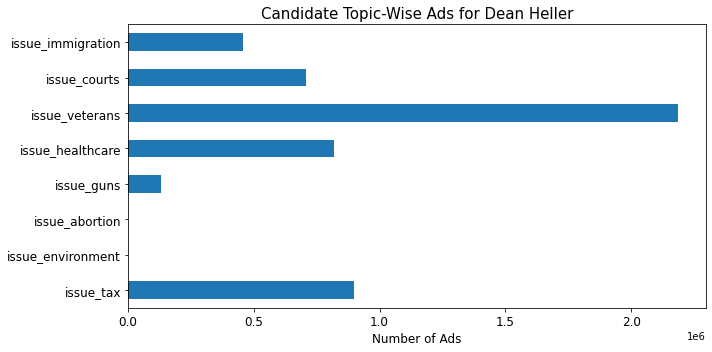

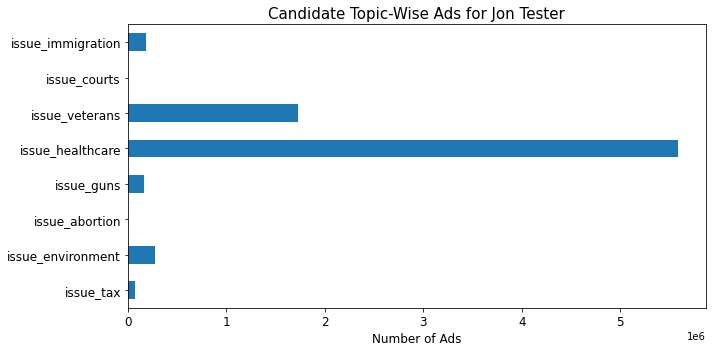

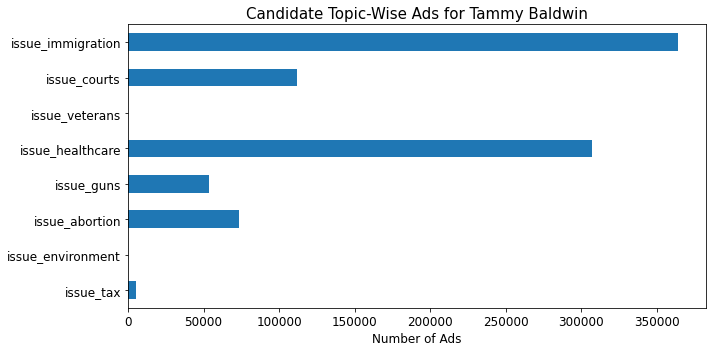

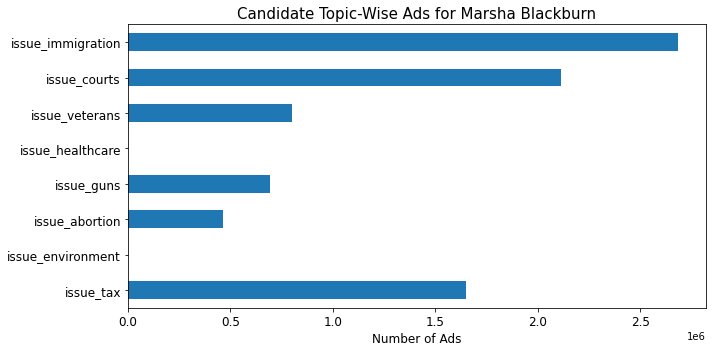

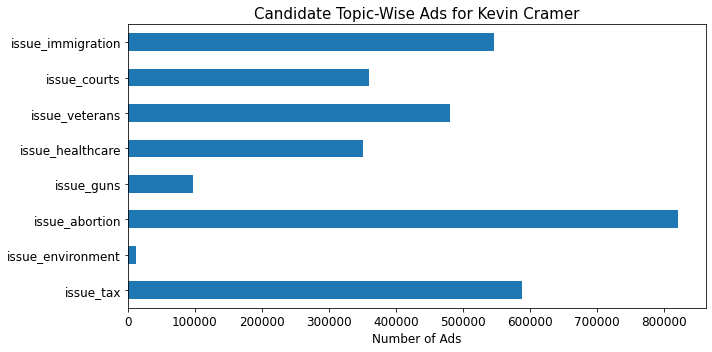

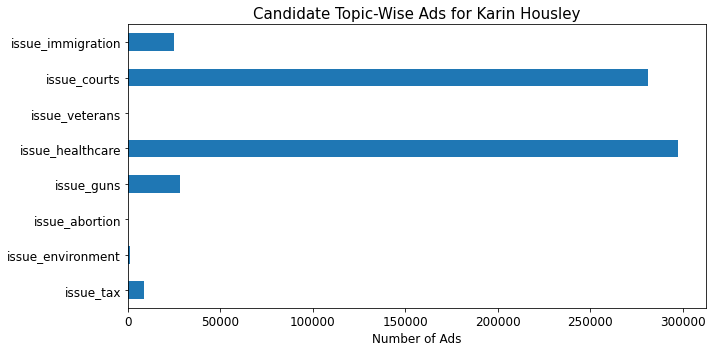

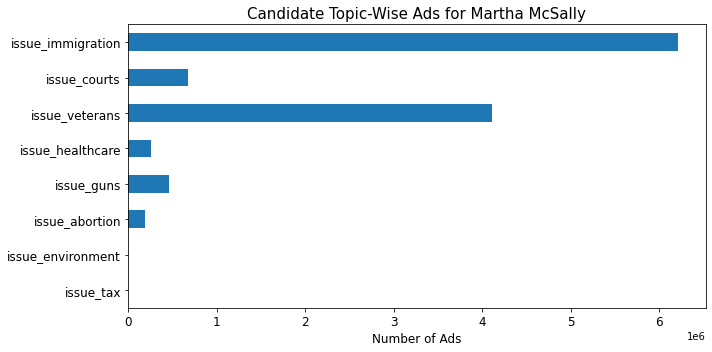

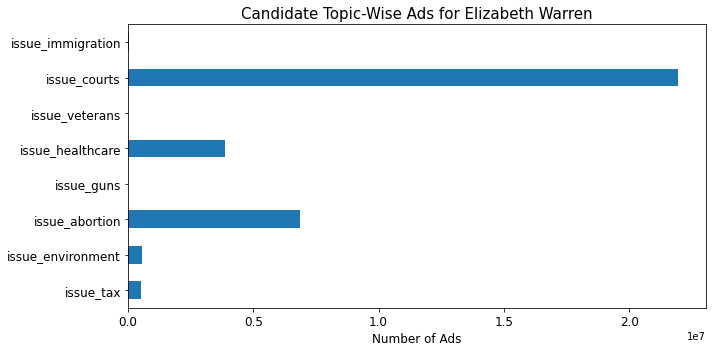

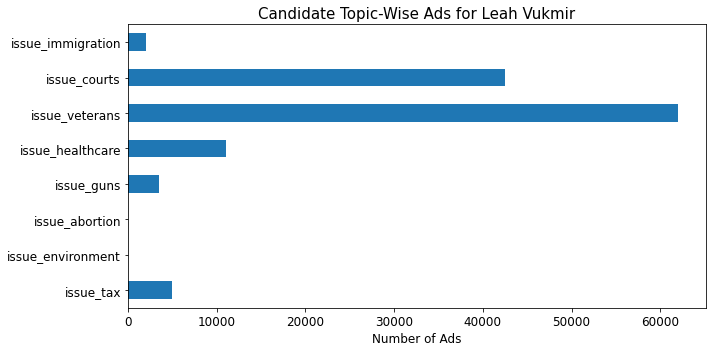

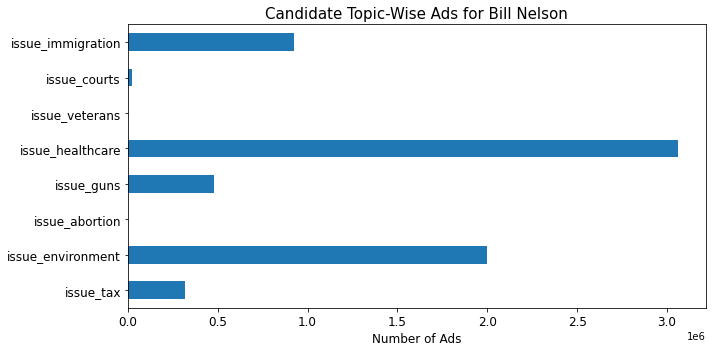

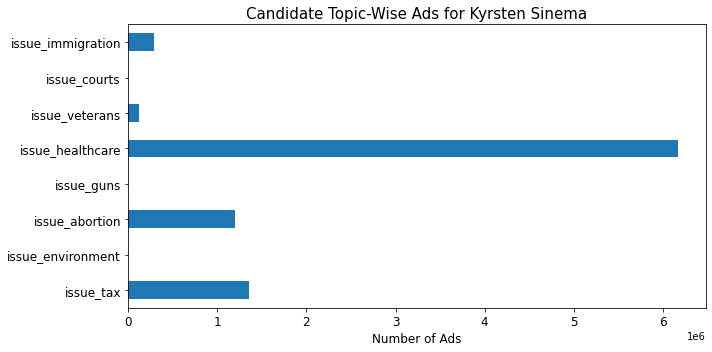

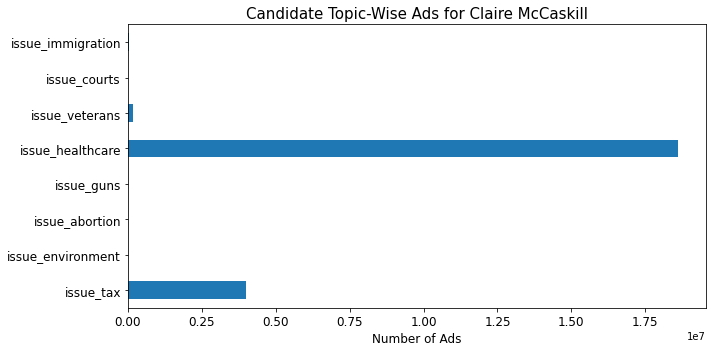

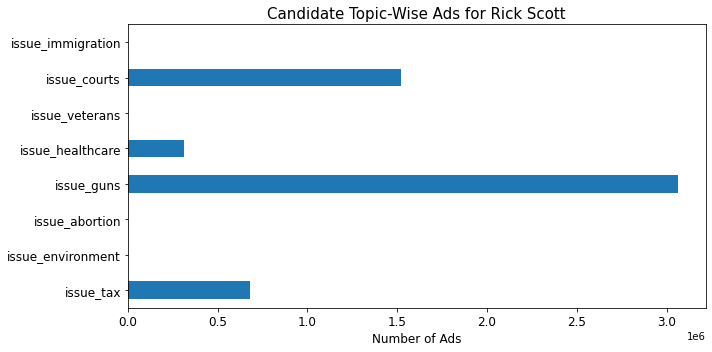

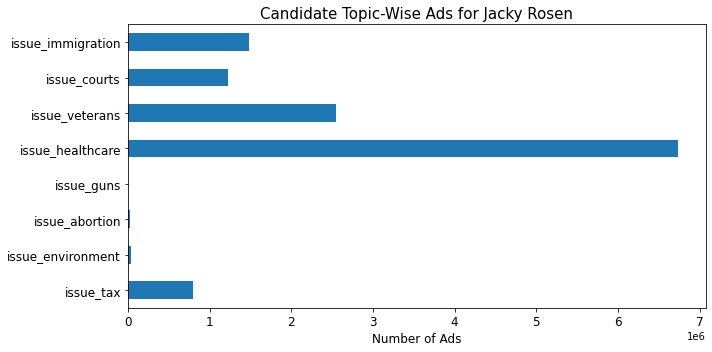

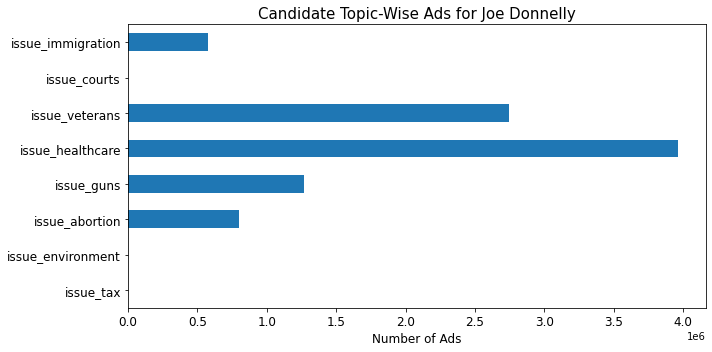

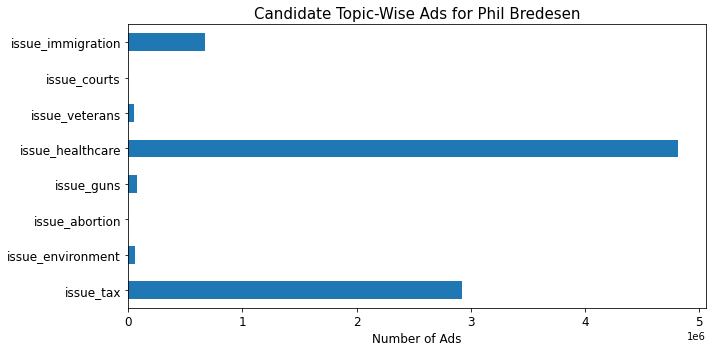

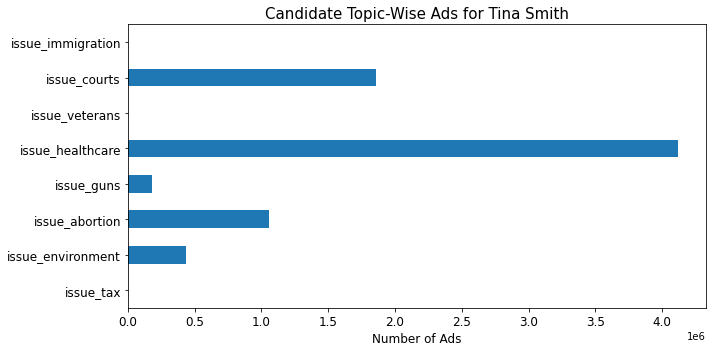

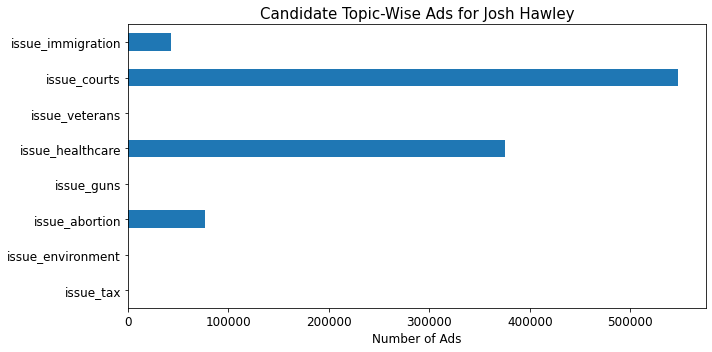

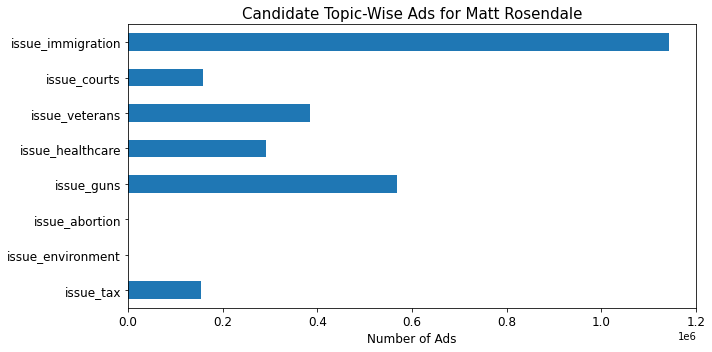

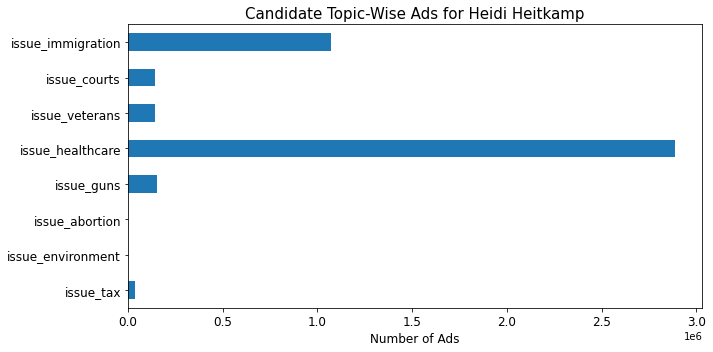

In [53]:
for candidate in candidate_top12:
    analyze_impression(data_m, candidate=candidate, save=False)

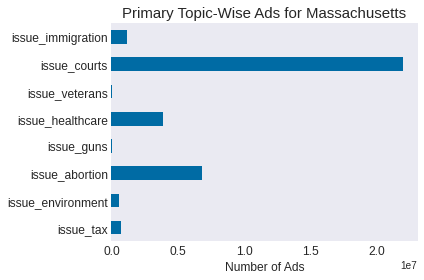

In [70]:
analyze_impression(data_m,top12states[1],save=False)

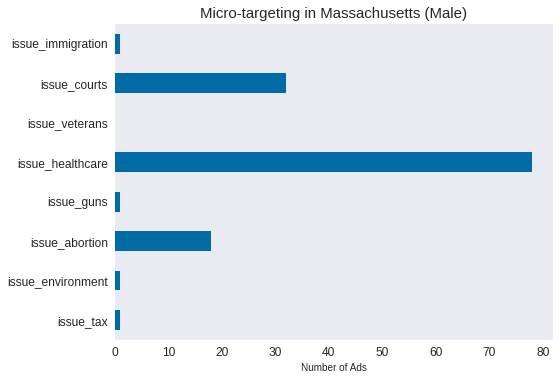

In [142]:
df = data_m[data_m['state']==top12states[1]]
df[df['male']>0.9][focus_topics].sum().plot(kind='barh')
plt.xlabel("Number of Ads",fontsize=10)
plt.title(f"Micro-targeting in {top12states[1]} (Male)", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

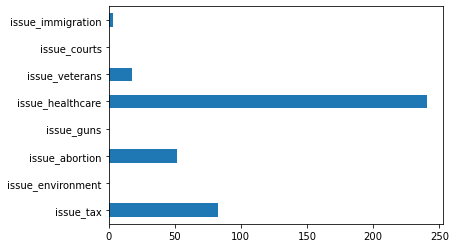

In [63]:
df[df['female']>0.9][focus_topics].sum().plot(kind='barh')

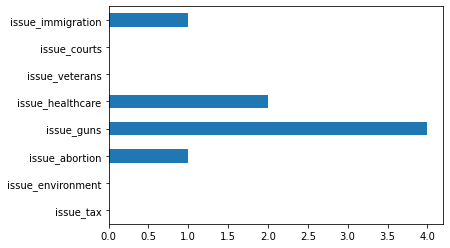

In [78]:
df = data_m[data_m["state"]=="Indiana"]
df[df['age55_64']>0.8][focus_topics].sum().plot(kind='barh')

In [ ]:
['age18_24', 'age25_34', 'age35_44', 'age45_54', 'age55_64', 'age65plus']

In [71]:
pd.DataFrame(df[df['male']>0.9][focus_topics].sum(), columns=['count'])

count
issue_tax           43.0
issue_environment    0.0
issue_abortion       0.0
issue_guns           0.0
issue_healthcare    60.0
issue_veterans       4.0
issue_courts         0.0
issue_immigration    5.0